In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'food11-image-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F432700%2F821742%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240512%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240512T084811Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D4b1f742c8f28ca36e4c626552aabb21ed2ee37221124481d2cda339394d69a2d40cd6b0819b438d48bb77b78076f408bc74f79a704df9ac4b6e0373bd90d84e8d4bc5b30b92a797ad479469f8dffa8e5246c82ac4c3cb43e135a453145cf2c59dc017af3df31c62f9253d848d105a125b3feaa1cb7845ed6bb29f1f1f9958f2ae911ceeb0e64104a257b20fdfcee6e720c3957bd06509f4b773324844c14b4d78bfebf094dd728c9e6a72ff1374658e8d56c2be6773f8ca2496f557296592539f0201a6aaa6a76a12fb5b7d2dc7982bfa1b7ba36ccc7150c02046f0be00fa09c4caab80ea312921c51139bc3e252e1df14f34adedfe74411def784d870da77d2'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


In [ ]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import pathlib
import cv2


In [ ]:
def random_images_labels(folder, samples_per_class):
    class_names = os.listdir(folder)

    fig, axs = plt.subplots(len(class_names), samples_per_class, figsize=(15, 3*len(class_names)))

    for i, class_name in enumerate(class_names):
        class_folder = os.path.join(folder, class_name)
        image_files = os.listdir(class_folder)
        random.shuffle(image_files)

        for j in range(samples_per_class):
            img_path = os.path.join(class_folder, image_files[j])
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            if samples_per_class == 1:
                ax = axs[i]
            else:
                ax = axs[i, j]

            ax.imshow(img)
            ax.set_title(class_name)
            ax.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
def plot_class_distribution(data_folder):
    class_names = os.listdir(data_folder)
    num_classes = len(class_names)

    image_counts = []
    for class_name in class_names:
        class_folder = os.path.join(data_folder, class_name)
        image_count = len(os.listdir(class_folder))
        image_counts.append(image_count)

    plt.figure(figsize=(8, 8))
    plt.pie(image_counts, labels=class_names, autopct='%1.1f%%')
    plt.axis('equal')
    plt.title('Распределение изображений по классам')
    plt.show()

In [ ]:
def classes_image_count(data_folder):
    class_names = os.listdir(data_folder)
    all_images = 0
    for class_name in class_names:
        class_folder = os.path.join(data_folder, class_name)
        image_count = len(os.listdir(class_folder))
        all_images += image_count
        print(f"Класс: {class_name}. Количество изображений: {image_count}")
    print("Всего изображений: ", all_images)

In [ ]:
main_dir = '/kaggle/input/food11-image-dataset'
train_path = main_dir + '/training'
valid_path = main_dir + '/validation'
test_path = main_dir + '/evaluation'

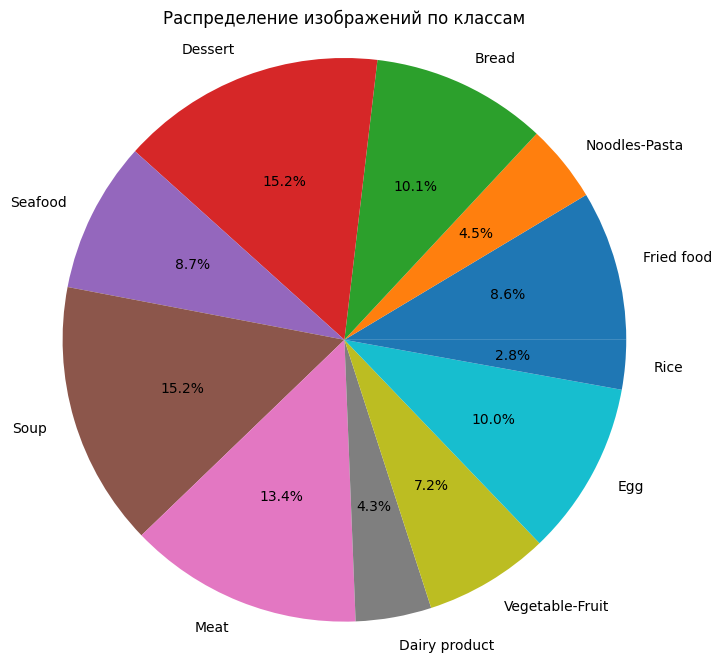

In [ ]:
plot_class_distribution(train_path)

In [ ]:
classes_image_count(train_path)

Класс: Fried food. Количество изображений: 848
Класс: Noodles-Pasta. Количество изображений: 440
Класс: Bread. Количество изображений: 994
Класс: Dessert. Количество изображений: 1500
Класс: Seafood. Количество изображений: 855
Класс: Soup. Количество изображений: 1500
Класс: Meat. Количество изображений: 1325
Класс: Dairy product. Количество изображений: 429
Класс: Vegetable-Fruit. Количество изображений: 709
Класс: Egg. Количество изображений: 986
Класс: Rice. Количество изображений: 280
Всего изображений:  9866


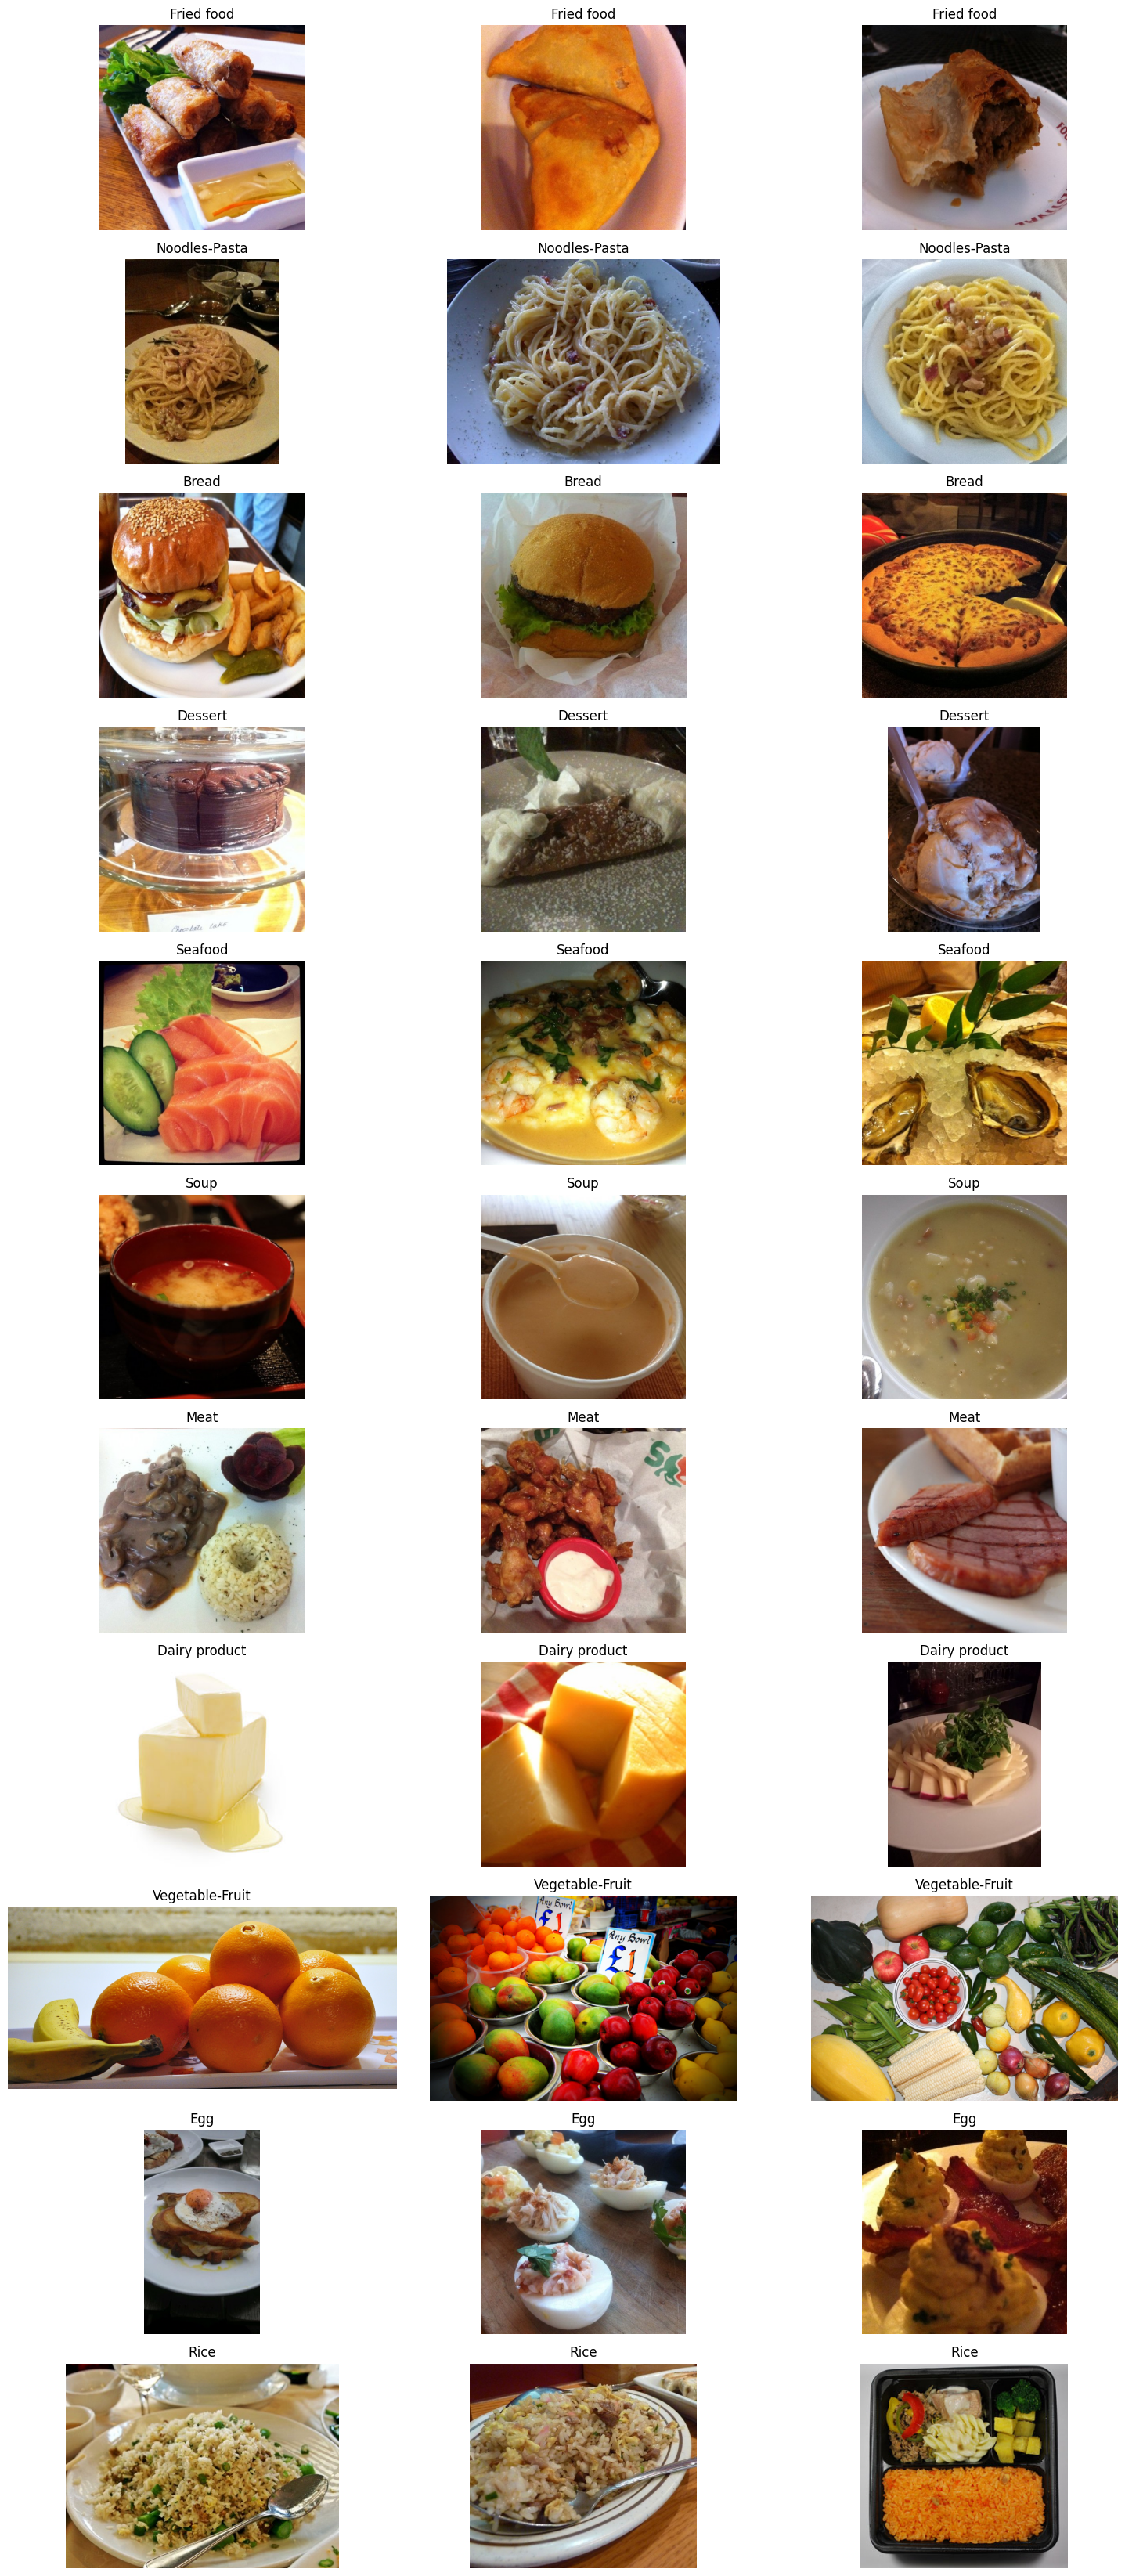

In [ ]:
random_images_labels(train_path, 3)

In [ ]:
seed = 42
batch_size = 64
image_size = 224

In [ ]:
import tensorflow as tf
train = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    labels='inferred',
    label_mode='categorical',
    image_size=(image_size, image_size),
    batch_size=batch_size,
    seed=seed
)
valid = tf.keras.preprocessing.image_dataset_from_directory(
    valid_path,
    labels='inferred',
    label_mode='categorical',
    image_size=(image_size, image_size),
    batch_size=batch_size,
    seed=seed
)
test = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    labels='inferred',
    label_mode='categorical',
    image_size=(image_size, image_size),
    batch_size=batch_size,
    seed=seed
)

2024-05-12 06:05:34.369562: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-12 06:05:34.369658: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-12 06:05:34.469354: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 9866 files belonging to 11 classes.
Found 3430 files belonging to 11 classes.
Found 3347 files belonging to 11 classes.


In [ ]:
num_classes = len(train.class_names)
num_classes

11

In [ ]:
image_shape = (image_size, image_size)

# **Инициализация baseline моделей**

In [ ]:
base_model_ENV2BO = tf.keras.applications.EfficientNetV2B0(
    include_top=False
)
preprocess_input_ENV2BO = tf.keras.applications.efficientnet_v2.preprocess_input

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
base_model_RN50V2 = tf.keras.applications.ResNet50V2(
    include_top=False
)
preprocess_input_RN50V2 = tf.keras.applications.resnet_v2.preprocess_input

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
base_model_ENV2S = tf.keras.applications.EfficientNetV2S(
    include_top=False
)
preprocess_input_ENV2S = tf.keras.applications.efficientnet_v2.preprocess_input

82420632/82420632 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
def build_model(base_model, preprocess):
    base_model.trainable = False
    input_layer = tf.keras.layers.Input(shape=image_shape+(3,), name='input_layer')
    data = preprocess(input_layer)
    data = base_model(data)
    data = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(data)
    output_layer = tf.keras.layers.Dense(num_classes, activation="softmax", name="output_layer")(data)
    model = tf.keras.Model(input_layer, output_layer)

    return model

# **Построение моделей**

In [ ]:
efficientnet_model = build_model(base_model_ENV2BO, preprocess_input_ENV2BO)
efficientnet_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 7, 7, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling_layer    │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 11)             │        14,091 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,933,403 (22.63 MB)

 Trainable params: 14,091 (55.04 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

In [ ]:
resnet_model = build_model(base_model_RN50V2, preprocess_input_RN50V2)
resnet_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling_layer    │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 11)             │        22,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,587,339 (89.98 MB)

 Trainable params: 22,539 (88.04 KB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [ ]:
efficientnet_model2 = build_model(base_model_ENV2S, preprocess_input_ENV2S)
efficientnet_model2.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-s (Functional)   │ (None, 7, 7, 1280)     │    20,331,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling_layer    │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 11)             │        14,091 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,345,451 (77.61 MB)

 Trainable params: 14,091 (55.04 KB)

 Non-trainable params: 20,331,360 (77.56 MB)

In [ ]:
from tensorflow.keras.optimizers import Adam

In [ ]:
epochs=20

# **Callbacks**

In [ ]:
# def create_early_stop_callback(monitor='val_loss',
#                                   min_delta=0.0001,
#                                   patience=5,
#                                   restore_best_weights=True):
#     early_stop_callback = tf.keras.callbacks.EarlyStopping(
#             monitor=monitor, min_delta=min_delta,
#             patience=patience, restore_best_weights=restore_best_weights)
#     return early_stop_callback

In [ ]:
def create_checkpoint_callback(dir_name, experiment_name):
    # Создание директории, если она не существует
    os.makedirs(dir_name, exist_ok=True)
    # Путь для сохранения чекпоинтов
    filepath = os.path.join(dir_name, experiment_name + '.weights.h5')
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=filepath, monitor='val_accuracy', save_best_only=True,
        save_weights_only=True, save_freq='epoch')
    print(f"INFO :: Saving Checkpoint to: {filepath}")
    return checkpoint_callback

# **Обучение моделей**

In [ ]:
efficientnet_model.compile(loss='categorical_crossentropy',
                    optimizer=Adam(),
                    metrics=['accuracy'])
history_efficientnet_model = efficientnet_model.fit(train, epochs=epochs,
                                                    validation_data=valid)

Epoch 1/20
  2/155 ━━━━━━━━━━━━━━━━━━━━ 13s 91ms/step - accuracy: 0.0820 - loss: 2.4969   

I0000 00:00:1715494005.255525     120 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1715494005.319060     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step - accuracy: 0.5767 - loss: 1.3969

W0000 00:00:1715494056.648825     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715494065.115180     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


155/155 ━━━━━━━━━━━━━━━━━━━━ 126s 502ms/step - accuracy: 0.5776 - loss: 1.3941 - val_accuracy: 0.8321 - val_loss: 0.5714
Epoch 2/20


W0000 00:00:1715494082.711462     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


155/155 ━━━━━━━━━━━━━━━━━━━━ 23s 147ms/step - accuracy: 0.8469 - loss: 0.5100 - val_accuracy: 0.8548 - val_loss: 0.4650
Epoch 3/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 42s 155ms/step - accuracy: 0.8715 - loss: 0.4116 - val_accuracy: 0.8659 - val_loss: 0.4208
Epoch 4/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 24s 154ms/step - accuracy: 0.8903 - loss: 0.3578 - val_accuracy: 0.8746 - val_loss: 0.3952
Epoch 5/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 25s 153ms/step - accuracy: 0.8947 - loss: 0.3329 - val_accuracy: 0.8799 - val_loss: 0.3777
Epoch 6/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 25s 155ms/step - accuracy: 0.9037 - loss: 0.3028 - val_accuracy: 0.8840 - val_loss: 0.3689
Epoch 7/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 25s 155ms/step - accuracy: 0.9086 - loss: 0.2973 - val_accuracy: 0.8848 - val_loss: 0.3562
Epoch 8/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 25s 158ms/step - accuracy: 0.9166 - loss: 0.2720 - val_accuracy: 0.8886 - val_loss: 0.3485
Epoch 9/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 40s 152ms/step - accuracy: 0.9188 - loss: 0.2662 - val

In [ ]:
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=Adam(),
                     metrics=["accuracy"])
history_resnet_model = resnet_model.fit(train, epochs=epochs,
                                        validation_data=valid)

Epoch 1/20
  1/155 ━━━━━━━━━━━━━━━━━━━━ 1:09:43 27s/step - accuracy: 0.1094 - loss: 3.3129

W0000 00:00:1715494619.637066     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.5503 - loss: 1.4346

W0000 00:00:1715494649.346340     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715494654.734143     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


155/155 ━━━━━━━━━━━━━━━━━━━━ 82s 357ms/step - accuracy: 0.5513 - loss: 1.4316 - val_accuracy: 0.7825 - val_loss: 0.6530
Epoch 2/20


W0000 00:00:1715494674.684992     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


155/155 ━━━━━━━━━━━━━━━━━━━━ 32s 201ms/step - accuracy: 0.8242 - loss: 0.5446 - val_accuracy: 0.8064 - val_loss: 0.5816
Epoch 3/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 31s 195ms/step - accuracy: 0.8565 - loss: 0.4408 - val_accuracy: 0.8143 - val_loss: 0.5629
Epoch 4/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 31s 196ms/step - accuracy: 0.8779 - loss: 0.3811 - val_accuracy: 0.8216 - val_loss: 0.5443
Epoch 5/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 31s 197ms/step - accuracy: 0.8910 - loss: 0.3424 - val_accuracy: 0.8210 - val_loss: 0.5390
Epoch 6/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 31s 195ms/step - accuracy: 0.9018 - loss: 0.3070 - val_accuracy: 0.8257 - val_loss: 0.5422
Epoch 7/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 31s 194ms/step - accuracy: 0.9164 - loss: 0.2779 - val_accuracy: 0.8271 - val_loss: 0.5353
Epoch 8/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 31s 197ms/step - accuracy: 0.9274 - loss: 0.2499 - val_accuracy: 0.8265 - val_loss: 0.5469
Epoch 9/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 31s 195ms/step - accuracy: 0.9334 - loss: 0.2319 - val

In [ ]:
efficientnet_model2.compile(loss='categorical_crossentropy',
                    optimizer=Adam(),
                    metrics=['accuracy'])
history_efficientnet_model2 = efficientnet_model2.fit(train, epochs=epochs,
                                                    validation_data=valid)

Epoch 1/20
  1/155 ━━━━━━━━━━━━━━━━━━━━ 4:09:49 97s/step - accuracy: 0.0781 - loss: 2.5223

W0000 00:00:1715495360.809123     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 607ms/step - accuracy: 0.6077 - loss: 1.3087

W0000 00:00:1715495454.385651     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715495466.785024     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


155/155 ━━━━━━━━━━━━━━━━━━━━ 227s 841ms/step - accuracy: 0.6085 - loss: 1.3061 - val_accuracy: 0.8242 - val_loss: 0.5773
Epoch 2/20


W0000 00:00:1715495490.371512     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


155/155 ━━━━━━━━━━━━━━━━━━━━ 42s 265ms/step - accuracy: 0.8364 - loss: 0.5319 - val_accuracy: 0.8536 - val_loss: 0.4824
Epoch 3/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 41s 258ms/step - accuracy: 0.8584 - loss: 0.4412 - val_accuracy: 0.8603 - val_loss: 0.4443
Epoch 4/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 41s 262ms/step - accuracy: 0.8720 - loss: 0.4054 - val_accuracy: 0.8703 - val_loss: 0.4170
Epoch 5/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 41s 260ms/step - accuracy: 0.8833 - loss: 0.3633 - val_accuracy: 0.8784 - val_loss: 0.3975
Epoch 6/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 41s 261ms/step - accuracy: 0.8913 - loss: 0.3457 - val_accuracy: 0.8781 - val_loss: 0.3890
Epoch 7/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 41s 261ms/step - accuracy: 0.8920 - loss: 0.3320 - val_accuracy: 0.8819 - val_loss: 0.3775
Epoch 8/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 41s 260ms/step - accuracy: 0.8931 - loss: 0.3123 - val_accuracy: 0.8834 - val_loss: 0.3729
Epoch 9/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 41s 261ms/step - accuracy: 0.9048 - loss: 0.3034 - val

<Axes: title={'center': 'Resnet50V2-based model'}>

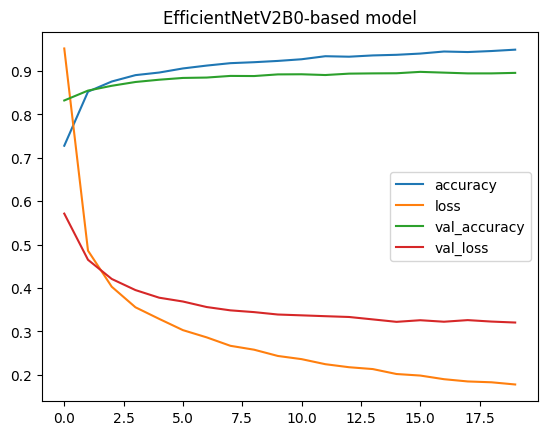

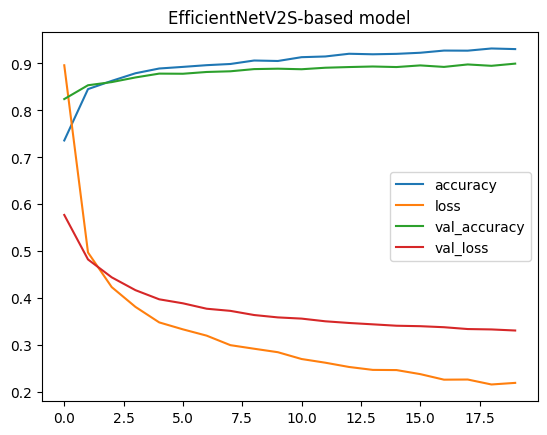

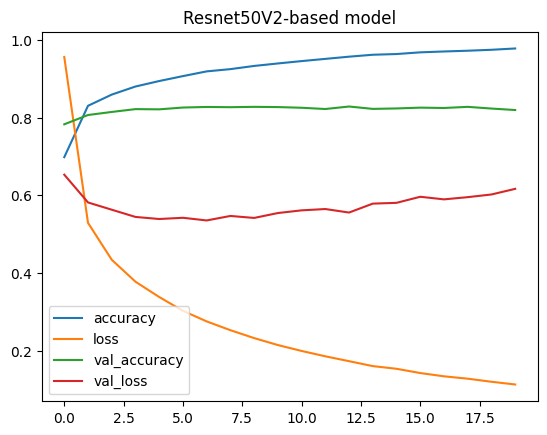

In [ ]:
pd.DataFrame(history_efficientnet_model.history).plot(title="EfficientNetV2B0-based model")

pd.DataFrame(history_efficientnet_model2.history).plot(title="EfficientNetV2S-based model")

pd.DataFrame(history_resnet_model.history).plot(title="Resnet50V2-based model")

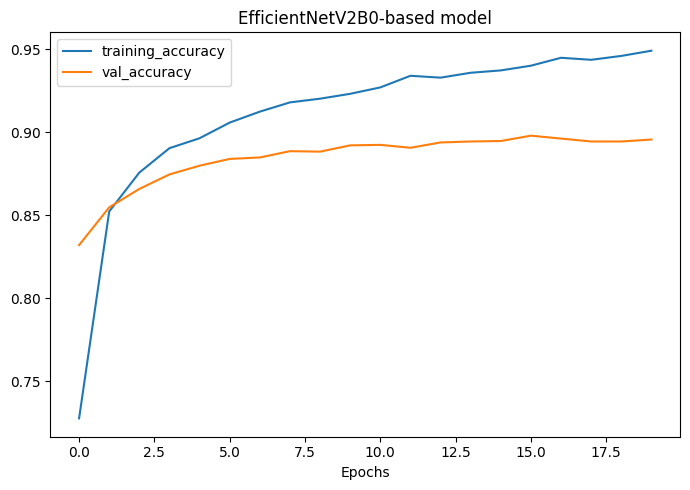

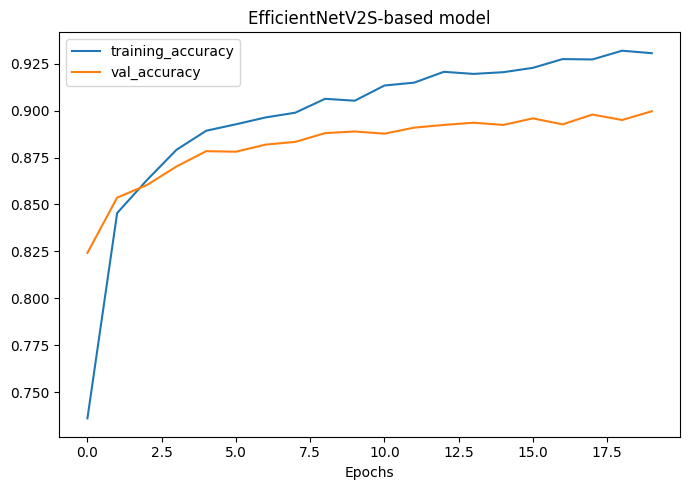

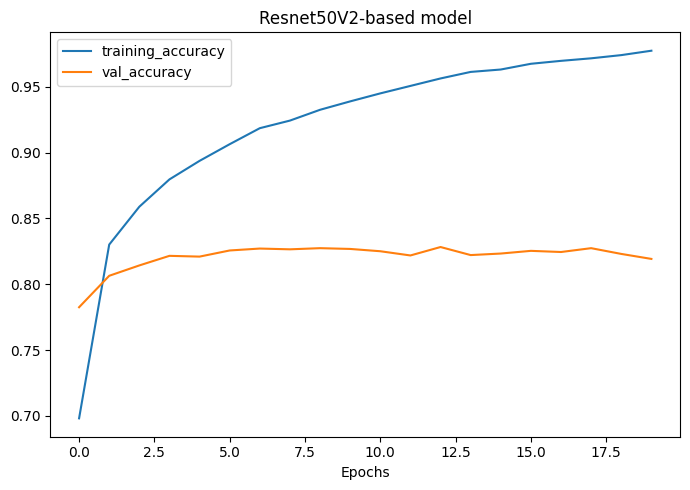

In [ ]:
def plot_accuracy_curves(history1, title1, history2, title2, history3, title3):
    accuracy1 = history1.history['accuracy']
    val_accuracy1 = history1.history['val_accuracy']
    epochs1 = range(len(history1.history['accuracy']))

    accuracy2 = history2.history['accuracy']
    val_accuracy2 = history2.history['val_accuracy']
    epochs2 = range(len(history2.history['accuracy']))

    accuracy3 = history3.history['accuracy']
    val_accuracy3 = history3.history['val_accuracy']
    epochs3 = range(len(history3.history['accuracy']))

    plt.figure(figsize=(7, 5))

    plt.plot(epochs1, accuracy1, label='training_accuracy')
    plt.plot(epochs1, val_accuracy1, label='val_accuracy')
    plt.title(title1)
    plt.xlabel('Epochs')
    plt.legend()
    plt.tight_layout()

    plt.figure(figsize=(7, 5))
    plt.plot(epochs2, accuracy2, label='training_accuracy')
    plt.plot(epochs2, val_accuracy2, label='val_accuracy')
    plt.title(title2)
    plt.xlabel('Epochs')
    plt.legend()
    plt.tight_layout()

    plt.figure(figsize=(7, 5))
    plt.plot(epochs3, accuracy3, label='training_accuracy')
    plt.plot(epochs3, val_accuracy3, label='val_accuracy')
    plt.title(title3)
    plt.xlabel('Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()


plot_accuracy_curves(history1=history_efficientnet_model,
                     title1="EfficientNetV2B0-based model",
                     history2=history_efficientnet_model2,
                     title2="EfficientNetV2S-based model",
                     history3=history_resnet_model,
                     title3="Resnet50V2-based model"
                     )

In [ ]:
efficientnet_val_loss, efficientnet_val_accuracy = efficientnet_model.evaluate(valid)
print(f"EfficientNetV2B0-based model -- validation accuracy: {efficientnet_val_accuracy * 100:.2f}%")

efficientnet_val_loss2, efficientnet_val_accuracy2 = efficientnet_model2.evaluate(valid)
print(f"EfficientNetV2S-based model -- validation accuracy: {efficientnet_val_accuracy2 * 100:.2f}%")


resnet_val_loss, resnet_val_accuracy = resnet_model.evaluate(valid)
print(f"ResNet50V2-based model -- validation accuracy: {resnet_val_accuracy * 100:.2f}%")

54/54 ━━━━━━━━━━━━━━━━━━━━ 8s 117ms/step - accuracy: 0.8979 - loss: 0.3238
EfficientNetV2B0-based model -- validation accuracy: 89.56%
54/54 ━━━━━━━━━━━━━━━━━━━━ 12s 194ms/step - accuracy: 0.8977 - loss: 0.3398
EfficientNetV2S-based model -- validation accuracy: 89.97%
54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - accuracy: 0.8212 - loss: 0.6018
ResNet50V2-based model -- validation accuracy: 81.92%


In [ ]:

efficientnet_test_loss, efficientnet_test_accuracy = efficientnet_model.evaluate(test)
print(f"EfficientNetV2B0-based model -- test accuracy: {efficientnet_test_accuracy * 100:.2f}%")

efficientnet_test_loss2, efficientnet_test_accuracy2 = efficientnet_model2.evaluate(test)
print(f"EfficientNetV2S-based model -- test accuracy: {efficientnet_test_accuracy2 * 100:.2f}%")


resnet_test_loss, resnet_test_accuracy = resnet_model.evaluate(test)
print(f"ResNet50V2-based model -- test accuracy: {resnet_test_accuracy * 100:.2f}%")

53/53 ━━━━━━━━━━━━━━━━━━━━ 19s 330ms/step - accuracy: 0.9181 - loss: 0.2619


W0000 00:00:1715496756.757127     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


EfficientNetV2B0-based model -- test accuracy: 91.66%
53/53 ━━━━━━━━━━━━━━━━━━━━ 21s 390ms/step - accuracy: 0.9227 - loss: 0.2449


W0000 00:00:1715496778.136230     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


EfficientNetV2S-based model -- test accuracy: 91.84%
53/53 ━━━━━━━━━━━━━━━━━━━━ 18s 318ms/step - accuracy: 0.8448 - loss: 0.5210
ResNet50V2-based model -- test accuracy: 84.28%


W0000 00:00:1715496795.825340     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [ ]:
initial_epochs = 10
fine_tune_epochs = 10
final_epochs = initial_epochs + fine_tune_epochs

In [ ]:
model = build_model(base_model_ENV2BO, preprocess_input_ENV2BO)

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])
history_model = model.fit(train, epochs=initial_epochs,
                          validation_data=valid,
                          callbacks=[
                              create_checkpoint_callback('/kaggle/working/checkpoints', 'feature_extraction_model')]
                         )

INFO :: Saving Checkpoint to: /kaggle/working/checkpoints/feature_extraction_model.weights.h5
Epoch 1/10
  2/155 ━━━━━━━━━━━━━━━━━━━━ 13s 91ms/step - accuracy: 0.2344 - loss: 2.3108   

W0000 00:00:1715502287.228919     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.7502 - loss: 0.9411

W0000 00:00:1715502330.408811     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715502339.241739     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715502348.539162     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


155/155 ━━━━━━━━━━━━━━━━━━━━ 101s 401ms/step - accuracy: 0.7509 - loss: 0.9385 - val_accuracy: 0.8910 - val_loss: 0.3488
Epoch 2/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 24s 154ms/step - accuracy: 0.9216 - loss: 0.2640 - val_accuracy: 0.8980 - val_loss: 0.3207
Epoch 3/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 23s 144ms/step - accuracy: 0.9314 - loss: 0.2169 - val_accuracy: 0.9017 - val_loss: 0.3069
Epoch 4/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 25s 157ms/step - accuracy: 0.9428 - loss: 0.1888 - val_accuracy: 0.9029 - val_loss: 0.3024
Epoch 5/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 23s 142ms/step - accuracy: 0.9404 - loss: 0.1803 - val_accuracy: 0.9026 - val_loss: 0.3025
Epoch 6/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 24s 154ms/step - accuracy: 0.9458 - loss: 0.1630 - val_accuracy: 0.9064 - val_loss: 0.2985
Epoch 7/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 23s 144ms/step - accuracy: 0.9528 - loss: 0.1505 - val_accuracy: 0.9073 - val_loss: 0.2968
Epoch 8/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 24s 152ms/step - accuracy: 0.9544 - loss: 0.1404 - va

In [ ]:
model_validation_metric = model.evaluate(valid)
print(model_validation_metric)

checkpoint_path = '/kaggle/working/checkpoints/feature_extraction_model.weights.h5'
model.load_weights(checkpoint_path)

model_validation_metric_loaded = model.evaluate(valid)
print(model_validation_metric_loaded)

54/54 ━━━━━━━━━━━━━━━━━━━━ 8s 118ms/step - accuracy: 0.9158 - loss: 0.2974
[0.29316842555999756, 0.9102040529251099]
54/54 ━━━━━━━━━━━━━━━━━━━━ 8s 119ms/step - accuracy: 0.9094 - loss: 0.3181
[0.2931685149669647, 0.9102040529251099]


In [ ]:
for layer in model.layers:
    print(layer, layer.trainable)

<InputLayer name=input_layer, built=True> True
<Functional name=efficientnetv2-b0, built=True> False
<GlobalAveragePooling2D name=global_average_pooling_layer, built=True> True
<Dense name=output_layer, built=True> True


In [ ]:
for layer_number, layer in enumerate(model.layers[1].layers):
    print(layer_number, layer.name, layer.trainable)

0 input_layer False
1 rescaling False
2 normalization False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

In [ ]:
print(len(model.layers[1].trainable_variables))

0


In [ ]:
base_model_ENV2BO.trainable = True


for layer in base_model_ENV2BO.layers[:-10]:
    layer.trainable = False

In [ ]:
print(len(model.layers[1].trainable_variables))


for layer in base_model_ENV2BO.layers[-10:]:
    print(layer.name, layer.trainable)

10
block6h_se_reduce True
block6h_se_expand True
block6h_se_excite True
block6h_project_conv True
block6h_project_bn True
block6h_drop True
block6h_add True
top_conv True
top_bn True
top_activation True


In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])



In [ ]:
for layer_number, layer in enumerate(model.layers[1].layers):
    print(layer_number, layer.name, layer.trainable)

0 input_layer False
1 rescaling False
2 normalization False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

In [ ]:
fine_tuning_model = model.fit(train, epochs=final_epochs,
                              initial_epoch=history_model.epoch[-1],
                              validation_data=valid)

Epoch 10/20
  2/155 ━━━━━━━━━━━━━━━━━━━━ 15s 100ms/step - accuracy: 0.9297 - loss: 0.1888  

W0000 00:00:1715502918.174859     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.9515 - loss: 0.1461

W0000 00:00:1715502962.497617     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715502969.923486     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


155/155 ━━━━━━━━━━━━━━━━━━━━ 102s 396ms/step - accuracy: 0.9516 - loss: 0.1460 - val_accuracy: 0.9105 - val_loss: 0.2885
Epoch 11/20


W0000 00:00:1715502979.099738     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


155/155 ━━━━━━━━━━━━━━━━━━━━ 24s 150ms/step - accuracy: 0.9607 - loss: 0.1209 - val_accuracy: 0.9122 - val_loss: 0.2843
Epoch 12/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 24s 152ms/step - accuracy: 0.9652 - loss: 0.1149 - val_accuracy: 0.9114 - val_loss: 0.2798
Epoch 13/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 22s 139ms/step - accuracy: 0.9610 - loss: 0.1223 - val_accuracy: 0.9143 - val_loss: 0.2812
Epoch 14/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 24s 154ms/step - accuracy: 0.9697 - loss: 0.1057 - val_accuracy: 0.9140 - val_loss: 0.2748
Epoch 15/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 24s 150ms/step - accuracy: 0.9723 - loss: 0.1011 - val_accuracy: 0.9155 - val_loss: 0.2749
Epoch 16/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 23s 144ms/step - accuracy: 0.9737 - loss: 0.0946 - val_accuracy: 0.9131 - val_loss: 0.2789
Epoch 17/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 24s 152ms/step - accuracy: 0.9722 - loss: 0.0957 - val_accuracy: 0.9175 - val_loss: 0.2708
Epoch 18/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 23s 147ms/step - accuracy: 0.9777 - loss: 0.083

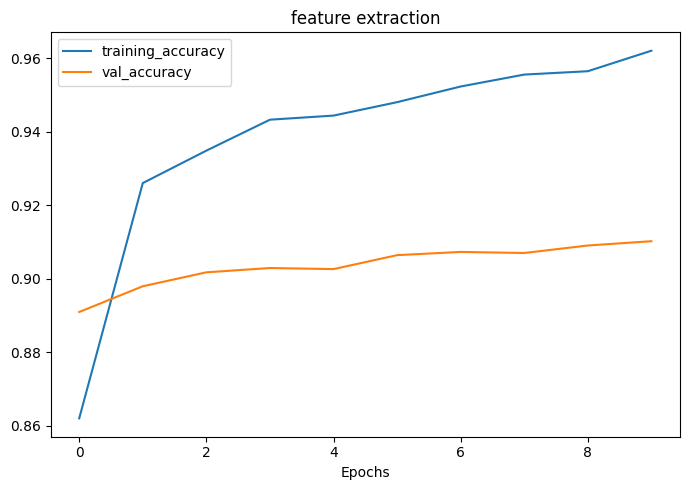

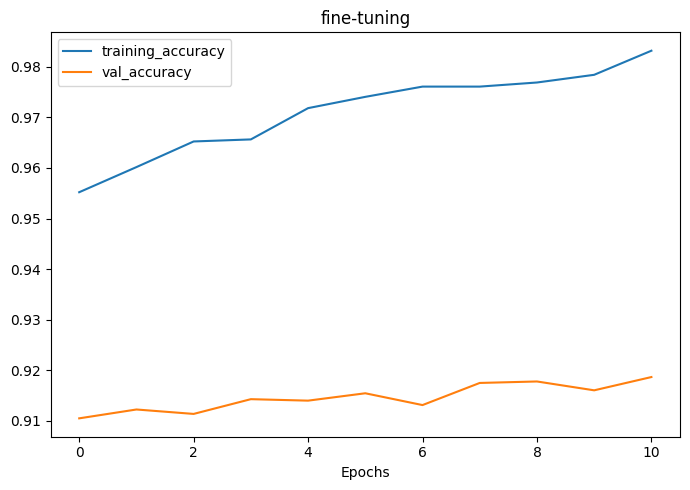

In [ ]:
def plot_accuracy_curves(history1, title1, history2, title2):
    accuracy1 = history1.history['accuracy']
    val_accuracy1 = history1.history['val_accuracy']
    epochs1 = range(len(history1.history['accuracy']))

    accuracy2 = history2.history['accuracy']
    val_accuracy2 = history2.history['val_accuracy']
    epochs2 = range(len(history2.history['accuracy']))

    plt.figure(figsize=(7, 5))
    plt.plot(epochs1, accuracy1, label='training_accuracy')
    plt.plot(epochs1, val_accuracy1, label='val_accuracy')
    plt.title(title1)
    plt.xlabel('Epochs')
    plt.legend()
    plt.tight_layout()

    plt.figure(figsize=(7, 5))
    plt.plot(epochs2, accuracy2, label='training_accuracy')
    plt.plot(epochs2, val_accuracy2, label='val_accuracy')
    plt.title(title2)
    plt.xlabel('Epochs')
    plt.legend()
    plt.tight_layout()

    plt.show()


plot_accuracy_curves(history_model, "feature extraction", fine_tuning_model, "fine-tuning")

10
21
[0.8620514869689941, 0.9260085225105286, 0.934826672077179, 0.9432393908500671, 0.9443543553352356, 0.9480032324790955, 0.9522603154182434, 0.9555037617683411, 0.9564159512519836, 0.9619906544685364, 0.955199658870697, 0.9601662158966064, 0.9652341604232788, 0.965639591217041, 0.9718224406242371, 0.9740523099899292, 0.9760794639587402, 0.9760794639587402, 0.9768903255462646, 0.9784107208251953, 0.9831745624542236]


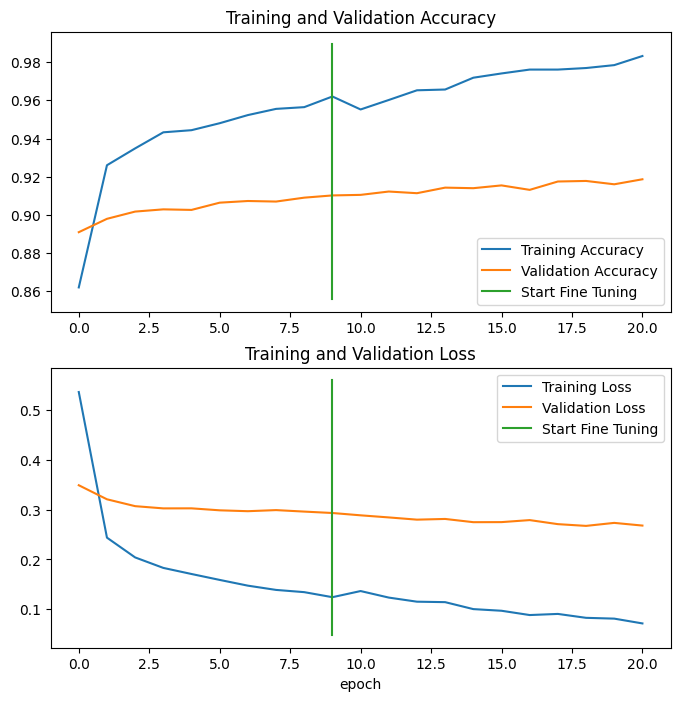

In [ ]:
def combine_training_curves(original_history, new_history, initial_epochs):
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    print(len(acc))

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    print(len(total_acc))
    print(total_acc)

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()


combine_training_curves(history_model, fine_tuning_model, initial_epochs)

In [ ]:
model_val_loss, model_val_accuracy = model.evaluate(valid)
print(f"EfficientNetV2B0-based model with fine-tuning -- validation accuracy: {model_val_accuracy * 100:.2f}%")

54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 109ms/step - accuracy: 0.9193 - loss: 0.2872
EfficientNetV2B0-based model with fine-tuning -- validation accuracy: 91.87%


In [ ]:
model_test_loss, model_test_accuracy = model.evaluate(test)
print(f"EfficientNetV2B0-based model with fine-tuning -- test accuracy: {model_test_accuracy * 100:.2f}%")

53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 119ms/step - accuracy: 0.9479 - loss: 0.1833
EfficientNetV2B0-based model with fine-tuning -- test accuracy: 94.23%
